In [6]:
import meep as mp
import meep.adjoint as mpa
import numpy as np

from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad

import nlopt

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

In [7]:
mp.verbosity(1)

Si = mp.Medium(index = 3.4)
Air = mp.Medium(index = 1)

In [8]:
resolution = 30

design_region_width = 4
design_region_height = 2
pml_size = 1.0

Sx = 2 * pml_size + design_region_width
Sy = 2 * pml_size + design_region_height + 5
cell_size = mp.Vector3(Sx, Sy)

wavelengths = np.array([1.5, 1.55, 1.6])
frequencies = 1/wavelengths
nf = len(frequencies) # number of frequencies

minimum_length = 0.09  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
design_region_resolution = int(resolution)

pml_layers = [mp.PML(pml_size)]

fcen = 1 / 1.55
width = 0.2
fwidth = width * fcen
source_center = [0, -(design_region_height / 2 + 1.5), 0]
source_size = mp.Vector3(Sx, 0, 0)
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center)]

Nx = int(round(design_region_resolution * design_region_width)) + 1
Ny = int(round(design_region_resolution * design_region_height)) + 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), Air, Si, grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)

In [9]:
def mapping(x, eta, beta):

    # filter
    filtered_field = mpa.conic_filter(
        x,
        filter_radius,
        design_region_width,
        design_region_height,
        design_region_resolution,
    )

    # projection
    projected_field = mpa.tanh_projection(filtered_field, beta, eta)

    # interpolate to actual materials
    return projected_field.flatten()


geometry = [
    mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    )
]

sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
)

     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


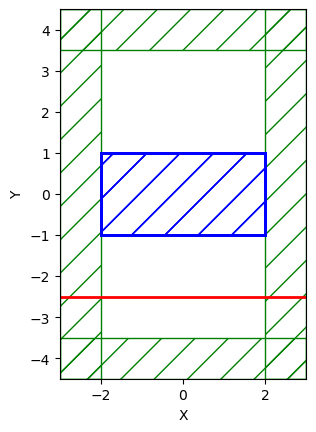

In [10]:
monitor_position, monitor_size = mp.Vector3(0,design_region_height/2+1.5), mp.Vector3(0.01,0)
FourierFields = mpa.FourierFields(sim,mp.Volume(center=monitor_position,size=monitor_size),mp.Ez,yee_grid=True)
ob_list = [FourierFields]

def J(fields):
    return npa.mean(npa.abs(fields[:,1]) ** 2) # The index 1 corresponds to the point at the center of our monitor.

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies,
    maximum_run_time=2000,
)
opt.plot2D(True)

In [11]:
evaluation_history = []
cur_iter = [0]

def f(v, gradient, beta):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([mapping(v, eta_i, beta)])  # compute objective and gradient

    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, beta, np.sum(dJ_du, axis=1)
        )  # backprop

    evaluation_history.append(np.real(f0))

    plt.figure()
    ax = plt.gca()
    opt.plot2D(
        False,
        ax=ax,
        plot_sources_flag=False,
        plot_monitors_flag=False,
        plot_boundaries_flag=False,
    )
    circ = Circle((2, 2), minimum_length / 2)
    ax.add_patch(circ)
    ax.axis("off")
    plt.show()

    cur_iter[0] = cur_iter[0] + 1

    return np.real(f0)

Current iteration: 1
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000306845 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0868828 s
-----------
on time step 23084 (time=384.733), 0.000173287 s/step
on time step 46088 (time=768.133), 0.000173886 s/step
on time step 69365 (time=1156.08), 0.000171849 s/step
on time step 92235 (time=1537.25), 0.000174907 s/step
on time step 115111 (time=1918.52), 0.000174861 s/step
run 0 finished at t = 2000.0166666666667 (120001 timesteps)
Starting adjoint run...


/home/min/miniconda3/envs/mp/lib/python3.8/site-packages/meep/adjoint/filter_source.py:187: RuntimeWarning: invalid value encountered in divide
  l2_err = np.sum(np.abs(H - H_hat.T) ** 2 / np.abs(H) ** 2)


on time step 16203 (time=270.05), 0.000246873 s/step
on time step 40517 (time=675.283), 0.00016452 s/step
on time step 65057 (time=1084.28), 0.000163005 s/step
on time step 89667 (time=1494.45), 0.000162538 s/step
run 1 finished at t = 1864.0 (111840 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


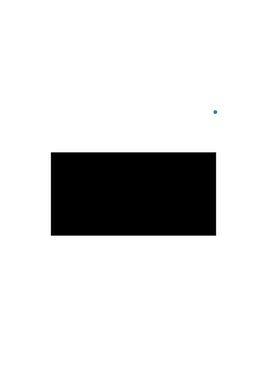

Current iteration: 2
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000109911 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0369749 s
-----------
on time step 22607 (time=376.783), 0.000176939 s/step
on time step 44730 (time=745.5), 0.000180816 s/step
on time step 67072 (time=1117.87), 0.000179042 s/step
on time step 85215 (time=1420.25), 0.000220473 s/step
on time step 107741 (time=1795.68), 0.000177574 s/step
run 2 finished at t = 2000.0166666666667 (120001 timesteps)
Starting adjoint run...
on time step 21585 (time=359.75), 0.000185316 s/step
on time step 45282 (time=754.7), 0.000168801 s/step
on time step 68832 (time=1147.2), 0.000169854 s/step
on time step 92496 (time=1541.6), 0.000169035 s/step
on time step 116163 (time=1936.05), 0.000169016 s/step
run 3 finished at t = 2000.01666666

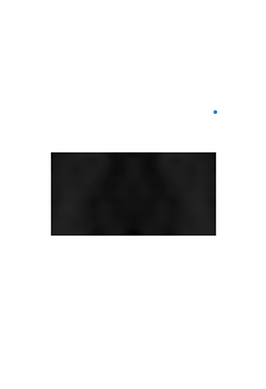

Current iteration: 3
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000112057 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0386419 s
-----------
on time step 22145 (time=369.083), 0.000180629 s/step
on time step 39994 (time=666.567), 0.000224105 s/step
run 4 finished at t = 768.9666666666667 (46138 timesteps)
Starting adjoint run...
on time step 21304 (time=355.067), 0.000187762 s/step
on time step 45132 (time=752.2), 0.00016787 s/step
run 5 finished at t = 1119.3166666666666 (67159 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


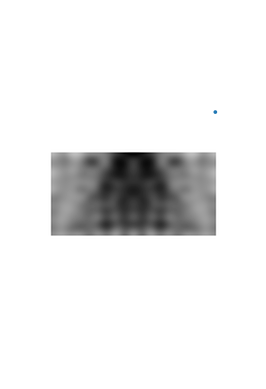

Current iteration: 4
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.00011611 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0365641 s
-----------
on time step 22685 (time=378.083), 0.000176332 s/step
on time step 45248 (time=754.133), 0.000177284 s/step
on time step 67943 (time=1132.38), 0.000176256 s/step
run 6 finished at t = 1222.45 (73347 timesteps)
Starting adjoint run...
on time step 19748 (time=329.133), 0.0002316 s/step
on time step 43638 (time=727.3), 0.000167438 s/step
on time step 68509 (time=1141.82), 0.000160834 s/step
on time step 92563 (time=1542.72), 0.000166295 s/step
run 7 finished at t = 1917.0833333333333 (115025 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


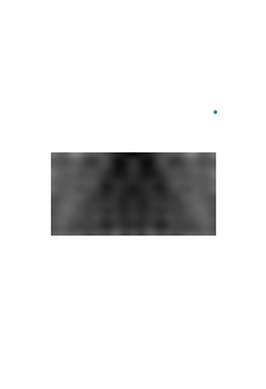

Current iteration: 5
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000128984 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0382478 s
-----------
on time step 22265 (time=371.083), 0.000179657 s/step
on time step 44513 (time=741.883), 0.000179798 s/step
on time step 67137 (time=1118.95), 0.000176805 s/step
run 8 finished at t = 1399.9 (83994 timesteps)
Starting adjoint run...
on time step 16049 (time=267.483), 0.000249243 s/step
on time step 39768 (time=662.8), 0.000168644 s/step
on time step 63672 (time=1061.2), 0.000167339 s/step
on time step 87588 (time=1459.8), 0.000167253 s/step
run 9 finished at t = 1677.45 (100647 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


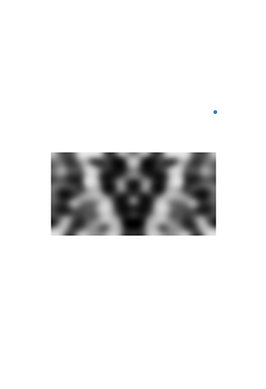

Current iteration: 6
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000113964 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.036598 s
-----------
on time step 22210 (time=370.167), 0.000180106 s/step
on time step 44487 (time=741.45), 0.000179558 s/step
on time step 67158 (time=1119.3), 0.000176438 s/step
run 10 finished at t = 1230.0333333333333 (73802 timesteps)
Starting adjoint run...
on time step 17271 (time=287.85), 0.000231605 s/step
on time step 41287 (time=688.117), 0.00016656 s/step
on time step 65104 (time=1085.07), 0.000167949 s/step
run 11 finished at t = 1166.3333333333333 (69980 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


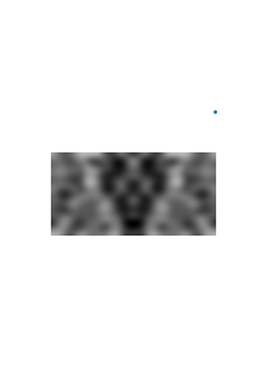

Current iteration: 7
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000111103 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0365059 s
-----------
on time step 22427 (time=373.783), 0.000178357 s/step
on time step 44840 (time=747.333), 0.000178471 s/step
on time step 67540 (time=1125.67), 0.000176213 s/step
on time step 90168 (time=1502.8), 0.00017678 s/step
on time step 112856 (time=1880.93), 0.00017631 s/step
run 12 finished at t = 2000.0166666666667 (120001 timesteps)
Starting adjoint run...
on time step 16929 (time=282.15), 0.000236281 s/step
on time step 40845 (time=680.75), 0.000167256 s/step
on time step 64765 (time=1079.42), 0.000167225 s/step
on time step 88692 (time=1478.2), 0.000167178 s/step
on time step 112718 (time=1878.63), 0.000166487 s/step
run 13 finished at t = 2000.01666

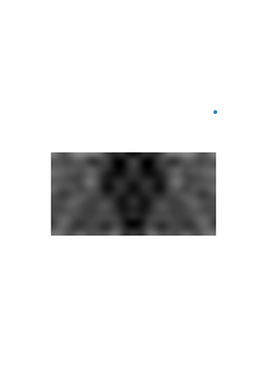

Current iteration: 8
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000109911 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.036365 s
-----------
on time step 22580 (time=376.333), 0.000177152 s/step
on time step 45012 (time=750.2), 0.000178321 s/step
on time step 67429 (time=1123.82), 0.000178442 s/step
on time step 86032 (time=1433.87), 0.000215024 s/step
on time step 108770 (time=1812.83), 0.00017592 s/step
run 14 finished at t = 2000.0166666666667 (120001 timesteps)
Starting adjoint run...
on time step 20833 (time=347.217), 0.000192006 s/step
on time step 44802 (time=746.7), 0.000166885 s/step
on time step 68465 (time=1141.08), 0.000169041 s/step
on time step 92228 (time=1537.13), 0.000168336 s/step
run 15 finished at t = 1907.9833333333333 (114479 timesteps)
Calculating gradient...
   

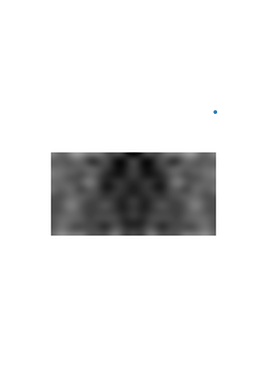

Current iteration: 9
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000123978 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0376189 s
-----------
on time step 22184 (time=369.733), 0.000180317 s/step
on time step 40427 (time=673.783), 0.000219269 s/step
on time step 62785 (time=1046.42), 0.00017891 s/step
on time step 85210 (time=1420.17), 0.000178379 s/step
on time step 107751 (time=1795.85), 0.000177461 s/step
run 16 finished at t = 2000.0166666666667 (120001 timesteps)
Starting adjoint run...
on time step 21024 (time=350.4), 0.000190265 s/step
on time step 44710 (time=745.167), 0.000168877 s/step
on time step 68358 (time=1139.3), 0.000169154 s/step
on time step 88006 (time=1466.77), 0.000203589 s/step
run 17 finished at t = 1801.8166666666666 (108109 timesteps)
Calculating gradient...
 

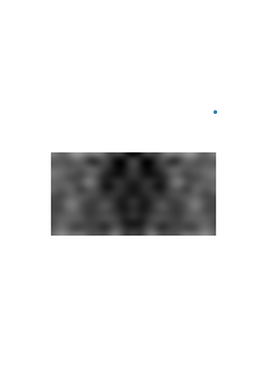

Current iteration: 10
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000108004 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0372798 s
-----------
on time step 22211 (time=370.183), 0.000180097 s/step
on time step 44398 (time=739.967), 0.000180286 s/step
on time step 66855 (time=1114.25), 0.00017812 s/step
run 18 finished at t = 1349.85 (80991 timesteps)
Starting adjoint run...
on time step 20698 (time=344.967), 0.000193258 s/step
on time step 44435 (time=740.583), 0.000168518 s/step
on time step 67984 (time=1133.07), 0.000169867 s/step
run 19 finished at t = 1145.1 (68706 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


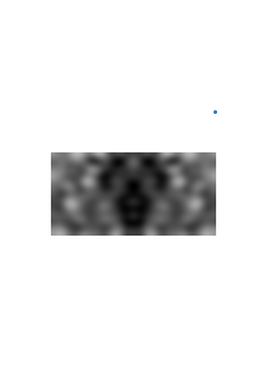

Current iteration: 11
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000124931 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.038017 s
-----------
on time step 18355 (time=305.917), 0.000217931 s/step
on time step 40505 (time=675.083), 0.000180594 s/step
on time step 62755 (time=1045.92), 0.000179782 s/step
on time step 85287 (time=1421.45), 0.000177532 s/step
on time step 107756 (time=1795.93), 0.000178027 s/step
run 20 finished at t = 1853.3833333333332 (111203 timesteps)
Starting adjoint run...
on time step 20980 (time=349.667), 0.000190659 s/step
on time step 44528 (time=742.133), 0.000169867 s/step
on time step 68325 (time=1138.75), 0.000168094 s/step
on time step 88033 (time=1467.22), 0.000202969 s/step
run 21 finished at t = 1651.6666666666667 (99100 timesteps)
Calculating gradient..

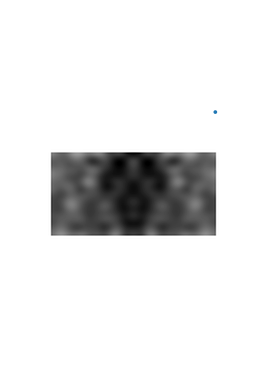

Current iteration: 12
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000112057 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0380468 s
-----------
on time step 22272 (time=371.2), 0.000179605 s/step
on time step 44797 (time=746.617), 0.000177588 s/step
run 22 finished at t = 908.5 (54510 timesteps)
Starting adjoint run...
on time step 20964 (time=349.4), 0.000190804 s/step
on time step 44558 (time=742.633), 0.000169537 s/step
run 23 finished at t = 958.55 (57513 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


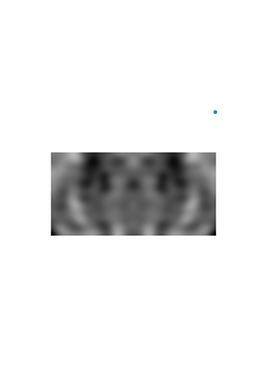

Current iteration: 13
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000126839 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.037143 s
-----------
on time step 21821 (time=363.683), 0.000183313 s/step
on time step 44000 (time=733.333), 0.000180355 s/step
on time step 62473 (time=1041.22), 0.000216534 s/step
on time step 84657 (time=1410.95), 0.000180312 s/step
run 24 finished at t = 1619.8166666666666 (97189 timesteps)
Starting adjoint run...
on time step 21200 (time=353.333), 0.000188683 s/step
on time step 44634 (time=743.9), 0.000170696 s/step
on time step 68024 (time=1133.73), 0.00017102 s/step
run 25 finished at t = 1233.0666666666666 (73984 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


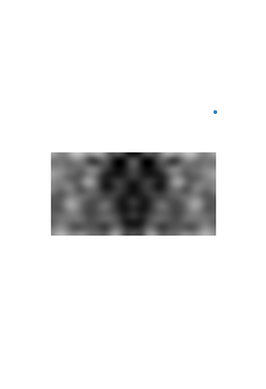

Current iteration: 14
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000108957 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.039257 s
-----------
on time step 22034 (time=367.233), 0.000181545 s/step
on time step 44253 (time=737.55), 0.000180031 s/step
on time step 62875 (time=1047.92), 0.000214802 s/step
on time step 85466 (time=1424.43), 0.000177068 s/step
on time step 108004 (time=1800.07), 0.000177485 s/step
run 26 finished at t = 2000.0166666666667 (120001 timesteps)
Starting adjoint run...
on time step 21190 (time=353.167), 0.00018877 s/step
on time step 44814 (time=746.9), 0.000169326 s/step
on time step 68401 (time=1140.02), 0.000169587 s/step
on time step 92344 (time=1539.07), 0.000167069 s/step
on time step 116212 (time=1936.87), 0.00016759 s/step
run 27 finished at t = 2000.0166

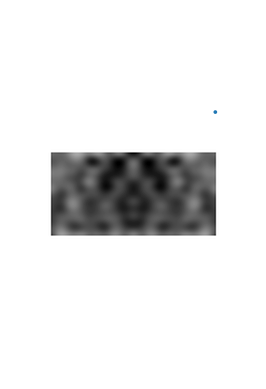

Current iteration: 15
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000117064 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.03794 s
-----------
on time step 18272 (time=304.533), 0.000218922 s/step
run 28 finished at t = 435.3 (26118 timesteps)
Starting adjoint run...
on time step 20661 (time=344.35), 0.000193606 s/step
run 29 finished at t = 480.8 (28848 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


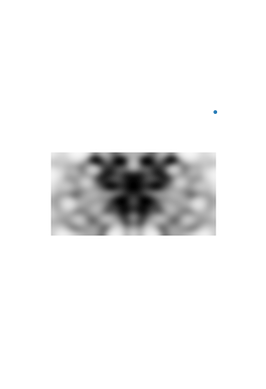

Current iteration: 16
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000109911 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0374851 s
-----------
on time step 22141 (time=369.017), 0.000180665 s/step
run 30 finished at t = 693.1333333333333 (41588 timesteps)
Starting adjoint run...
on time step 20206 (time=336.767), 0.000197962 s/step
run 31 finished at t = 670.3833333333333 (40223 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


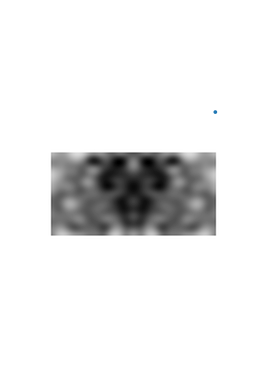

Current iteration: 17
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000166178 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.038204 s
-----------
on time step 22421 (time=373.683), 0.000178412 s/step
on time step 41072 (time=684.533), 0.000214473 s/step
on time step 63481 (time=1058.02), 0.000178505 s/step
on time step 85998 (time=1433.3), 0.000177649 s/step
on time step 108309 (time=1805.15), 0.000179291 s/step
run 32 finished at t = 1950.45 (117027 timesteps)
Starting adjoint run...
on time step 21217 (time=353.617), 0.000188532 s/step
on time step 45397 (time=756.617), 0.000165428 s/step
on time step 69285 (time=1154.75), 0.000167454 s/step
run 33 finished at t = 1278.5666666666666 (76714 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          ax

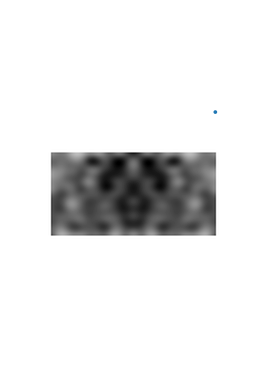

Current iteration: 18
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000111103 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0373819 s
-----------
on time step 21960 (time=366), 0.000182155 s/step
on time step 39755 (time=662.583), 0.000224791 s/step
on time step 61459 (time=1024.32), 0.000184298 s/step
on time step 83903 (time=1398.38), 0.000178229 s/step
on time step 106523 (time=1775.38), 0.000176842 s/step
run 34 finished at t = 2000.0166666666667 (120001 timesteps)
Starting adjoint run...
on time step 21871 (time=364.517), 0.000182898 s/step
on time step 45934 (time=765.567), 0.000166232 s/step
on time step 69783 (time=1163.05), 0.000167725 s/step
on time step 93480 (time=1558), 0.000198443 s/step
run 35 finished at t = 1901.9166666666667 (114115 timesteps)
Calculating gradient...
   

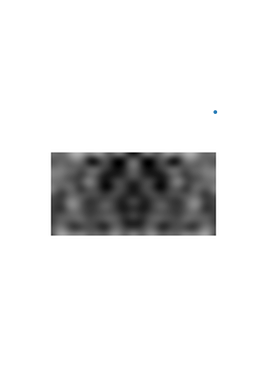

Current iteration: 19
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000115156 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0380499 s
-----------
on time step 21506 (time=358.433), 0.000186001 s/step
on time step 43649 (time=727.483), 0.000180645 s/step
on time step 65843 (time=1097.38), 0.000180232 s/step
on time step 88747 (time=1479.12), 0.000174643 s/step
run 36 finished at t = 1524.2666666666667 (91456 timesteps)
Starting adjoint run...
on time step 21119 (time=351.983), 0.00018941 s/step
on time step 44550 (time=742.5), 0.000170714 s/step
on time step 68083 (time=1134.72), 0.000169979 s/step
on time step 86676 (time=1444.6), 0.000215137 s/step
on time step 109916 (time=1831.93), 0.000172121 s/step
run 37 finished at t = 1862.4833333333333 (111749 timesteps)
Calculating gradient...
 

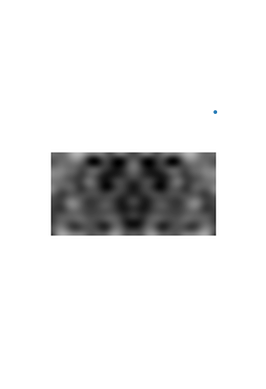

Current iteration: 20
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000111103 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0380421 s
-----------
on time step 22296 (time=371.6), 0.000179412 s/step
on time step 44516 (time=741.933), 0.000180031 s/step
on time step 67317 (time=1121.95), 0.000175436 s/step
on time step 90002 (time=1500.03), 0.000176335 s/step
on time step 112357 (time=1872.62), 0.000178935 s/step
run 38 finished at t = 2000.0166666666667 (120001 timesteps)
Starting adjoint run...
on time step 16692 (time=278.2), 0.000242389 s/step
on time step 39627 (time=660.45), 0.000174408 s/step
on time step 63012 (time=1050.2), 0.000171051 s/step
on time step 86564 (time=1442.73), 0.000169843 s/step
on time step 110235 (time=1837.25), 0.000168985 s/step
run 39 finished at t = 1897.3666

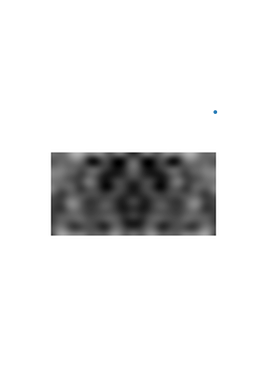

Current iteration: 21
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000110149 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0368252 s
-----------
on time step 22137 (time=368.95), 0.000180696 s/step
on time step 44434 (time=740.567), 0.0001794 s/step
on time step 66486 (time=1108.1), 0.000181395 s/step
on time step 87170 (time=1452.83), 0.000216559 s/step
on time step 108955 (time=1815.92), 0.000183616 s/step
run 40 finished at t = 2000.0166666666667 (120001 timesteps)
Starting adjoint run...
on time step 20989 (time=349.817), 0.000190576 s/step
on time step 44799 (time=746.65), 0.000168003 s/step
on time step 68634 (time=1143.9), 0.000167827 s/step
run 41 finished at t = 1299.8 (77988 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1

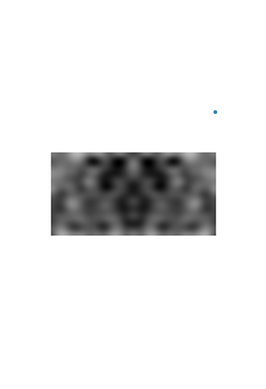

Current iteration: 22
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000109911 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0368111 s
-----------
on time step 22469 (time=374.483), 0.000178025 s/step
on time step 44654 (time=744.233), 0.000180308 s/step
on time step 67028 (time=1117.13), 0.00017878 s/step
on time step 85067 (time=1417.78), 0.00022175 s/step
on time step 107671 (time=1794.52), 0.000176964 s/step
run 42 finished at t = 2000.0166666666667 (120001 timesteps)
Starting adjoint run...
on time step 21315 (time=355.25), 0.000187666 s/step
on time step 45769 (time=762.817), 0.000163573 s/step
on time step 69936 (time=1165.6), 0.000165515 s/step
on time step 93750 (time=1562.5), 0.00016797 s/step
run 43 finished at t = 1785.1333333333332 (107108 timesteps)
Calculating gradient...
  

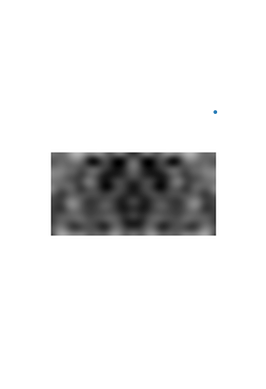

Current iteration: 23
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.00011301 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0384641 s
-----------
on time step 22450 (time=374.167), 0.000178177 s/step
on time step 40299 (time=671.65), 0.000224105 s/step
on time step 63052 (time=1050.87), 0.000175805 s/step
run 44 finished at t = 1404.45 (84267 timesteps)
Starting adjoint run...
on time step 21595 (time=359.917), 0.000185231 s/step
on time step 45757 (time=762.617), 0.000165553 s/step
run 45 finished at t = 952.4833333333333 (57149 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


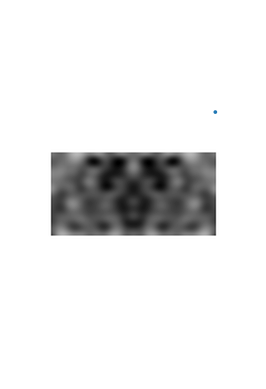

Current iteration: 24
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000111818 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0379169 s
-----------
on time step 22583 (time=376.383), 0.000177128 s/step
on time step 44836 (time=747.267), 0.000179756 s/step
on time step 67294 (time=1121.57), 0.000178118 s/step
on time step 85576 (time=1426.27), 0.000218801 s/step
run 46 finished at t = 1701.7166666666667 (102103 timesteps)
Starting adjoint run...
on time step 21397 (time=356.617), 0.000186942 s/step
on time step 45622 (time=760.367), 0.000165121 s/step
on time step 69734 (time=1162.23), 0.000165893 s/step
run 47 finished at t = 1528.8166666666666 (91729 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


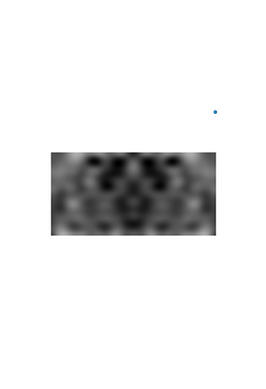

Current iteration: 25
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000136852 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0366161 s
-----------
on time step 22307 (time=371.783), 0.000179317 s/step
run 48 finished at t = 594.55 (35673 timesteps)
Starting adjoint run...
on time step 20603 (time=343.383), 0.000194149 s/step
run 49 finished at t = 582.4166666666666 (34945 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


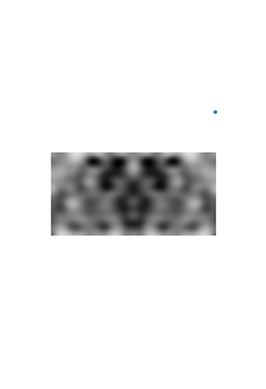

Current iteration: 26
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.00011301 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0377569 s
-----------
on time step 22414 (time=373.567), 0.000178467 s/step
on time step 45273 (time=754.55), 0.000174986 s/step
run 50 finished at t = 893.3333333333334 (53600 timesteps)
Starting adjoint run...
on time step 20407 (time=340.117), 0.000196017 s/step
on time step 44368 (time=739.467), 0.00016694 s/step
run 51 finished at t = 1095.05 (65703 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


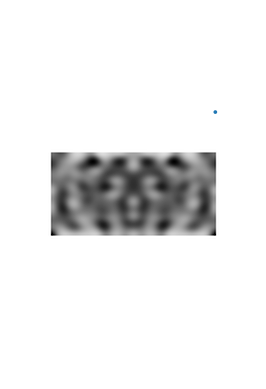

Current iteration: 27
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000112057 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0368941 s
-----------
on time step 22572 (time=376.2), 0.000177212 s/step
on time step 44816 (time=746.933), 0.000179824 s/step
run 52 finished at t = 753.8 (45228 timesteps)
Starting adjoint run...
on time step 16183 (time=269.717), 0.000247181 s/step
on time step 40093 (time=668.217), 0.000167297 s/step
run 53 finished at t = 712.85 (42771 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


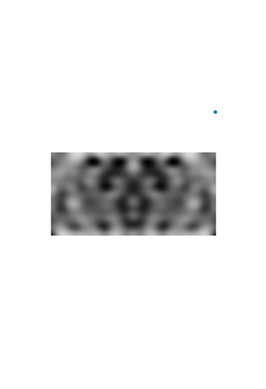

Current iteration: 28
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000108957 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.037442 s
-----------
on time step 22576 (time=376.267), 0.000177185 s/step
on time step 45481 (time=758.017), 0.000174635 s/step
run 54 finished at t = 906.9833333333333 (54419 timesteps)
Starting adjoint run...
on time step 21536 (time=358.933), 0.000185737 s/step
on time step 45415 (time=756.917), 0.000167516 s/step
run 55 finished at t = 863.0 (51780 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


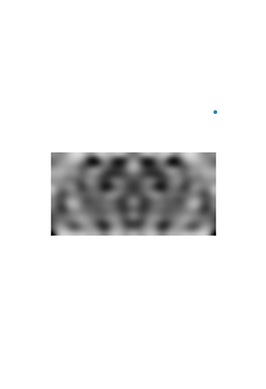

Current iteration: 29
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000111103 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.037966 s
-----------
on time step 22612 (time=376.867), 0.000176904 s/step
on time step 40882 (time=681.367), 0.000218942 s/step
run 56 finished at t = 952.4833333333333 (57149 timesteps)
Starting adjoint run...
on time step 20970 (time=349.5), 0.000190751 s/step
on time step 45092 (time=751.533), 0.00016583 s/step
run 57 finished at t = 1043.4833333333333 (62609 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


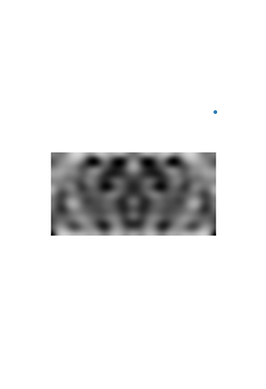

Current iteration: 30
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000110865 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0378811 s
-----------
on time step 22561 (time=376.017), 0.0001773 s/step
on time step 45142 (time=752.367), 0.000177141 s/step
on time step 67682 (time=1128.03), 0.000177467 s/step
run 58 finished at t = 1154.2 (69252 timesteps)
Starting adjoint run...
on time step 20558 (time=342.633), 0.000194579 s/step
on time step 39801 (time=663.35), 0.000207873 s/step
on time step 63923 (time=1065.38), 0.000165825 s/step
run 59 finished at t = 1101.1166666666666 (66067 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


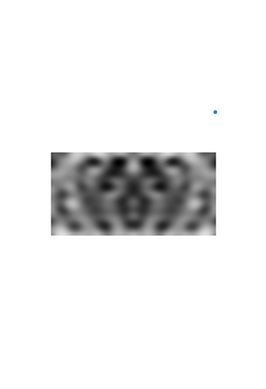

Current iteration: 31
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000125885 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0360999 s
-----------
on time step 22437 (time=373.95), 0.00017828 s/step
on time step 45066 (time=751.1), 0.000176771 s/step
run 60 finished at t = 947.9333333333333 (56876 timesteps)
Starting adjoint run...
on time step 21153 (time=352.55), 0.000189105 s/step
on time step 44962 (time=749.367), 0.000168007 s/step
on time step 68585 (time=1143.08), 0.000169328 s/step
run 61 finished at t = 1143.5833333333333 (68615 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


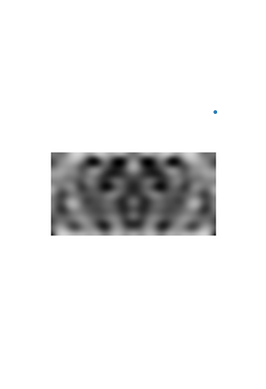

Current iteration: 32
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000109911 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.038074 s
-----------
on time step 21544 (time=359.067), 0.000185674 s/step
on time step 39796 (time=663.267), 0.000219161 s/step
run 62 finished at t = 954.0 (57240 timesteps)
Starting adjoint run...
on time step 21033 (time=350.55), 0.000190184 s/step
on time step 44919 (time=748.65), 0.000167466 s/step
run 63 finished at t = 878.1666666666666 (52690 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


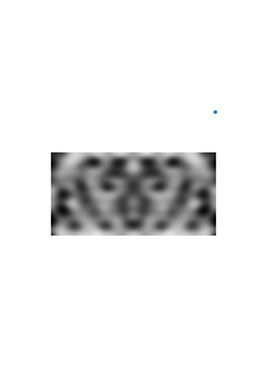

Current iteration: 33
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.00011611 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0376399 s
-----------
on time step 22188 (time=369.8), 0.000180285 s/step
on time step 44592 (time=743.2), 0.000178549 s/step
run 64 finished at t = 943.3833333333333 (56603 timesteps)
Starting adjoint run...
on time step 20787 (time=346.45), 0.000192435 s/step
on time step 39779 (time=662.983), 0.000210621 s/step
on time step 63578 (time=1059.63), 0.00016808 s/step
run 65 finished at t = 1061.6833333333334 (63701 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


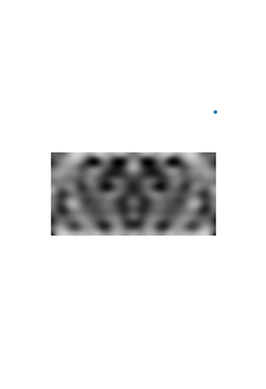

Current iteration: 34
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000108004 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0369198 s
-----------
on time step 22592 (time=376.533), 0.000177056 s/step
on time step 45180 (time=753), 0.000177086 s/step
run 66 finished at t = 879.6833333333333 (52781 timesteps)
Starting adjoint run...
on time step 21343 (time=355.717), 0.000187424 s/step
on time step 44811 (time=746.85), 0.000170451 s/step
on time step 68417 (time=1140.28), 0.000169449 s/step
run 67 finished at t = 1214.8666666666666 (72892 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


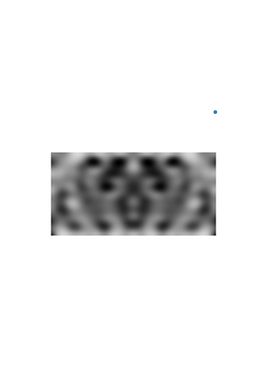

Current iteration: 35
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000112057 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.040076 s
-----------
on time step 21854 (time=364.233), 0.000183035 s/step
on time step 40243 (time=670.717), 0.00021753 s/step
run 68 finished at t = 931.25 (55875 timesteps)
Starting adjoint run...
on time step 21743 (time=362.383), 0.000183973 s/step
on time step 45592 (time=759.867), 0.00016773 s/step
on time step 69423 (time=1157.05), 0.000167849 s/step
run 69 finished at t = 1331.65 (79899 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


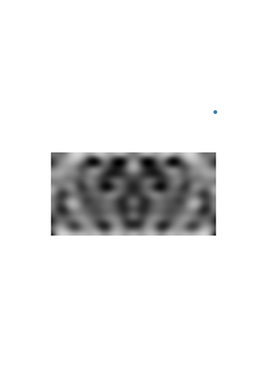

Current iteration: 36
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000117064 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.03774 s
-----------
on time step 22196 (time=369.933), 0.000180215 s/step
on time step 44545 (time=742.417), 0.000178985 s/step
run 70 finished at t = 866.0333333333333 (51962 timesteps)
Starting adjoint run...
on time step 20437 (time=340.617), 0.000195741 s/step
on time step 40215 (time=670.25), 0.000202251 s/step
run 71 finished at t = 1061.6833333333334 (63701 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


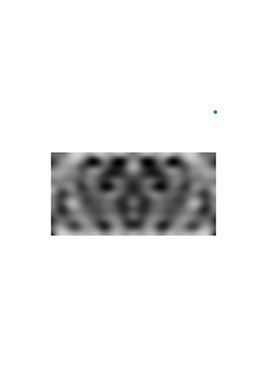

Current iteration: 37
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000118971 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0376391 s
-----------
on time step 22326 (time=372.1), 0.000179169 s/step
on time step 44818 (time=746.967), 0.000177849 s/step
run 72 finished at t = 781.1 (46866 timesteps)
Starting adjoint run...
on time step 20720 (time=345.333), 0.000193054 s/step
on time step 44852 (time=747.533), 0.000165756 s/step
run 73 finished at t = 805.3666666666667 (48322 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


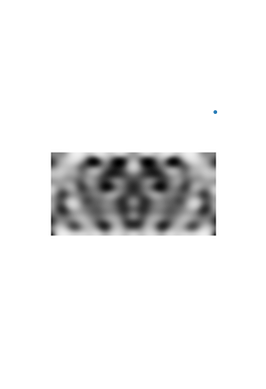

Current iteration: 38
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000111818 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0370281 s
-----------
on time step 22093 (time=368.217), 0.000181053 s/step
run 74 finished at t = 612.75 (36765 timesteps)
Starting adjoint run...
on time step 16789 (time=279.817), 0.000238253 s/step
on time step 40662 (time=677.7), 0.000167558 s/step
run 75 finished at t = 738.6333333333333 (44318 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


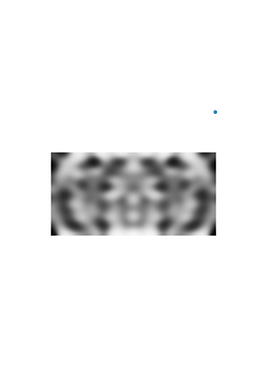

Current iteration: 39
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000108957 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0375738 s
-----------
on time step 22229 (time=370.483), 0.000179952 s/step
run 76 finished at t = 559.6666666666666 (33580 timesteps)
Starting adjoint run...
on time step 20874 (time=347.9), 0.000191626 s/step
run 77 finished at t = 677.9666666666667 (40678 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


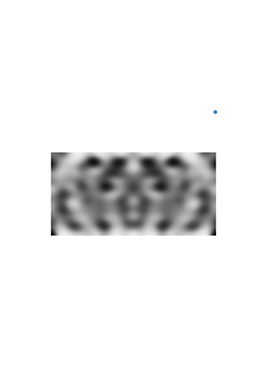

Current iteration: 40
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.00011301 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0369551 s
-----------
on time step 22327 (time=372.117), 0.000179161 s/step
run 78 finished at t = 650.6666666666666 (39040 timesteps)
Starting adjoint run...
on time step 20697 (time=344.95), 0.00019327 s/step
on time step 40654 (time=677.567), 0.000200437 s/step
run 79 finished at t = 721.95 (43317 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


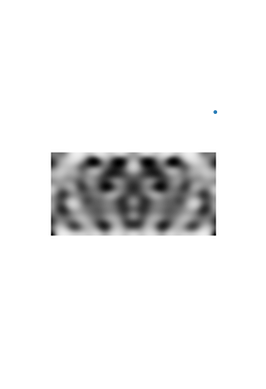

Current iteration: 41
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000108004 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0376382 s
-----------
on time step 22381 (time=373.017), 0.000178727 s/step
run 80 finished at t = 515.6833333333333 (30941 timesteps)
Starting adjoint run...
on time step 21030 (time=350.5), 0.000190205 s/step
run 81 finished at t = 734.0833333333334 (44045 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


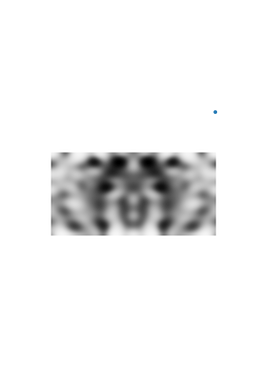

Current iteration: 42
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000154018 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.03826 s
-----------
on time step 22226 (time=370.433), 0.000179978 s/step
on time step 44386 (time=739.767), 0.000180507 s/step
on time step 66769 (time=1112.82), 0.000178708 s/step
run 82 finished at t = 1284.6333333333332 (77078 timesteps)
Starting adjoint run...
on time step 16852 (time=280.867), 0.000237364 s/step
on time step 40621 (time=677.017), 0.000168292 s/step
on time step 64516 (time=1075.27), 0.000167408 s/step
on time step 88421 (time=1473.68), 0.000167335 s/step
run 83 finished at t = 1621.3333333333333 (97280 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


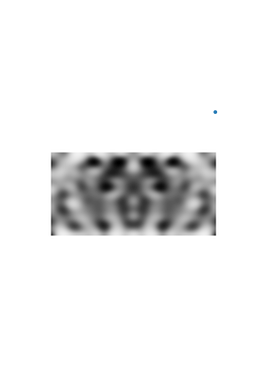

Current iteration: 43
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000121117 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0375829 s
-----------
on time step 22072 (time=367.867), 0.000181233 s/step
on time step 44357 (time=739.283), 0.000179499 s/step
run 84 finished at t = 993.4333333333333 (59606 timesteps)
Starting adjoint run...
on time step 21111 (time=351.85), 0.000189478 s/step
on time step 41110 (time=685.167), 0.000200013 s/step
run 85 finished at t = 920.6333333333333 (55238 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


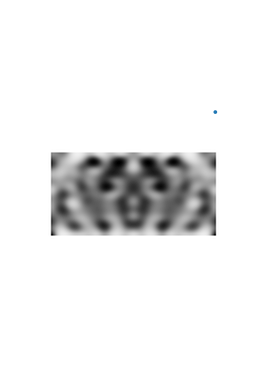

Current iteration: 44
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000112057 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.037226 s
-----------
on time step 22314 (time=371.9), 0.000179262 s/step
on time step 44968 (time=749.467), 0.000176577 s/step
run 86 finished at t = 947.9333333333333 (56876 timesteps)
Starting adjoint run...
on time step 20940 (time=349), 0.000191028 s/step
run 87 finished at t = 721.95 (43317 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


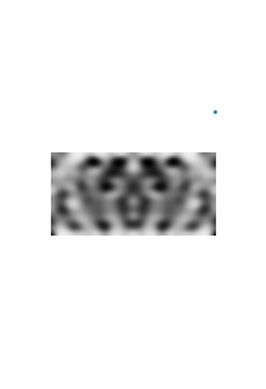

Current iteration: 45
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000111103 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.039937 s
-----------
on time step 22458 (time=374.3), 0.000178116 s/step
on time step 44970 (time=749.5), 0.000177686 s/step
run 88 finished at t = 897.8833333333333 (53873 timesteps)
Starting adjoint run...
on time step 16250 (time=270.833), 0.000246156 s/step
on time step 40102 (time=668.367), 0.000167706 s/step
run 89 finished at t = 957.0333333333333 (57422 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


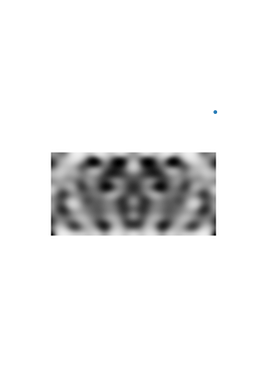

Current iteration: 46
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000110149 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.037559 s
-----------
on time step 22156 (time=369.267), 0.000180543 s/step
on time step 44414 (time=740.233), 0.000179712 s/step
run 90 finished at t = 1085.95 (65157 timesteps)
Starting adjoint run...
on time step 21369 (time=356.15), 0.000187193 s/step
on time step 45231 (time=753.85), 0.000167636 s/step
run 91 finished at t = 960.0666666666666 (57604 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


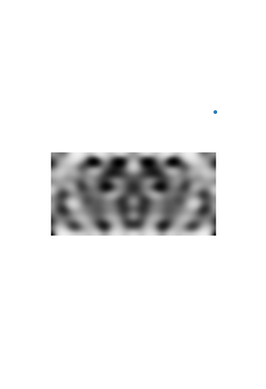

Current iteration: 47
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000110149 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.037113 s
-----------
on time step 18713 (time=311.883), 0.000213762 s/step
on time step 41369 (time=689.483), 0.000176557 s/step
on time step 64037 (time=1067.28), 0.000176461 s/step
run 92 finished at t = 1387.7666666666667 (83266 timesteps)
Starting adjoint run...
on time step 20960 (time=349.333), 0.000190847 s/step
on time step 44948 (time=749.133), 0.000166751 s/step
on time step 68894 (time=1148.23), 0.000167046 s/step
run 93 finished at t = 1528.8166666666666 (91729 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


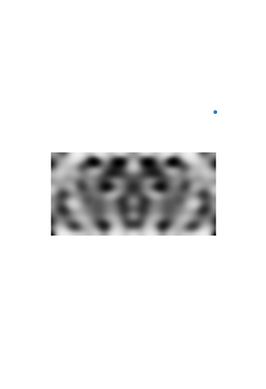

Current iteration: 48
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000112057 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.037117 s
-----------
on time step 18552 (time=309.2), 0.000215612 s/step
on time step 41115 (time=685.25), 0.000177282 s/step
on time step 63489 (time=1058.15), 0.000178784 s/step
run 94 finished at t = 1085.95 (65157 timesteps)
Starting adjoint run...
on time step 20966 (time=349.433), 0.000190789 s/step
on time step 44687 (time=744.783), 0.000168632 s/step
on time step 68451 (time=1140.85), 0.000168327 s/step
run 95 finished at t = 1298.2833333333333 (77897 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


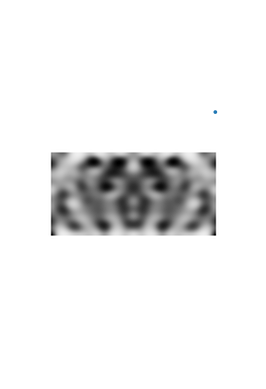

Current iteration: 49
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000108957 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0373912 s
-----------
on time step 22232 (time=370.533), 0.000179921 s/step
on time step 44556 (time=742.6), 0.000179184 s/step
on time step 63337 (time=1055.62), 0.000212986 s/step
on time step 85980 (time=1433), 0.000176656 s/step
run 96 finished at t = 1466.6333333333332 (87998 timesteps)
Starting adjoint run...
on time step 20695 (time=344.917), 0.000193284 s/step
on time step 44583 (time=743.05), 0.000167451 s/step
on time step 68546 (time=1142.43), 0.000166928 s/step
on time step 92571 (time=1542.85), 0.0001665 s/step
run 97 finished at t = 1816.9833333333333 (109019 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
        

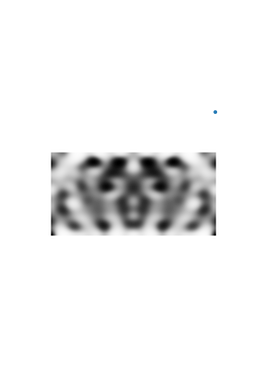

Current iteration: 50
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000111103 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0369999 s
-----------
on time step 22019 (time=366.983), 0.000181667 s/step
on time step 41724 (time=695.4), 0.000212349 s/step
on time step 64282 (time=1071.37), 0.000177327 s/step
run 98 finished at t = 1240.65 (74439 timesteps)
Starting adjoint run...
on time step 20774 (time=346.233), 0.000192554 s/step
on time step 44606 (time=743.433), 0.000167847 s/step
on time step 68420 (time=1140.33), 0.000167975 s/step
on time step 92169 (time=1536.15), 0.000168433 s/step
run 99 finished at t = 1548.5333333333333 (92912 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


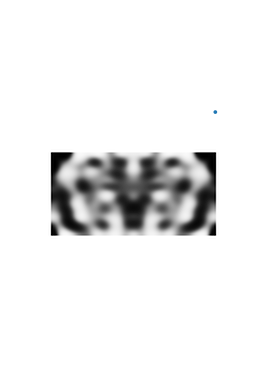

Current iteration: 51
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.00011301 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.037451 s
-----------
on time step 21960 (time=366), 0.000182159 s/step
run 100 finished at t = 724.9833333333333 (43499 timesteps)
Starting adjoint run...
on time step 16554 (time=275.9), 0.000241636 s/step
on time step 40079 (time=667.983), 0.000170033 s/step
run 101 finished at t = 803.85 (48231 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


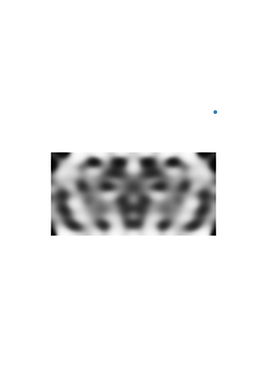

Current iteration: 52
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000128984 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.037406 s
-----------
on time step 22090 (time=368.167), 0.000181083 s/step
run 102 finished at t = 667.35 (40041 timesteps)
Starting adjoint run...
on time step 20769 (time=346.15), 0.000192598 s/step
on time step 44576 (time=742.933), 0.000168023 s/step
run 103 finished at t = 753.8 (45228 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


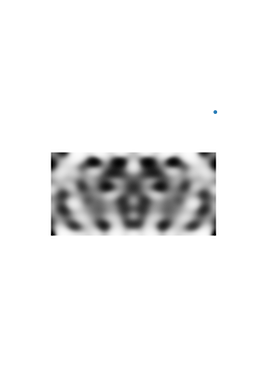

Current iteration: 53
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000109911 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.037642 s
-----------
on time step 22277 (time=371.283), 0.000179559 s/step
on time step 44635 (time=743.917), 0.000178909 s/step
on time step 63378 (time=1056.3), 0.000213418 s/step
run 104 finished at t = 1242.1666666666667 (74530 timesteps)
Starting adjoint run...
on time step 21101 (time=351.683), 0.000189565 s/step
on time step 44892 (time=748.2), 0.000168131 s/step
on time step 68734 (time=1145.57), 0.000167775 s/step
run 105 finished at t = 1434.7833333333333 (86087 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


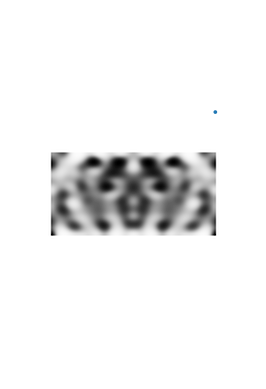

Current iteration: 54
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000112057 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0372419 s
-----------
on time step 22289 (time=371.483), 0.000179465 s/step
on time step 44449 (time=740.817), 0.000180507 s/step
on time step 66635 (time=1110.58), 0.0001803 s/step
on time step 85556 (time=1425.93), 0.000211406 s/step
run 106 finished at t = 1527.3 (91638 timesteps)
Starting adjoint run...
on time step 20661 (time=344.35), 0.000193604 s/step
on time step 44457 (time=740.95), 0.000168098 s/step
on time step 68293 (time=1138.22), 0.000167815 s/step
run 107 finished at t = 1506.0666666666666 (90364 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


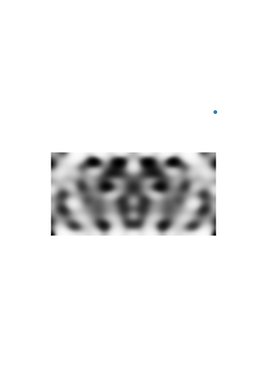

Current iteration: 55
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000121117 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0377939 s
-----------
on time step 22062 (time=367.7), 0.000181309 s/step
run 108 finished at t = 687.0666666666666 (41224 timesteps)
Starting adjoint run...
on time step 20784 (time=346.4), 0.000192463 s/step
on time step 40788 (time=679.8), 0.000199967 s/step
run 109 finished at t = 762.9 (45774 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


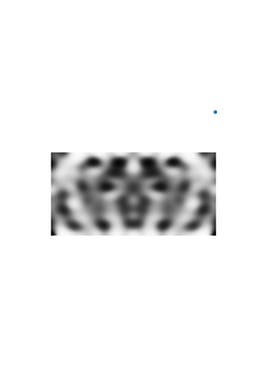

Current iteration: 56
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000115871 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.038619 s
-----------
on time step 22383 (time=373.05), 0.00017871 s/step
on time step 44768 (time=746.133), 0.000178695 s/step
on time step 67210 (time=1120.17), 0.000178252 s/step
on time step 89780 (time=1496.33), 0.000177234 s/step
run 110 finished at t = 1512.1333333333332 (90728 timesteps)
Starting adjoint run...
on time step 20813 (time=346.883), 0.000192192 s/step
on time step 44259 (time=737.65), 0.000170608 s/step
on time step 67754 (time=1129.23), 0.000170256 s/step
on time step 87052 (time=1450.87), 0.000207284 s/step
run 111 finished at t = 1648.6333333333332 (98918 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
   

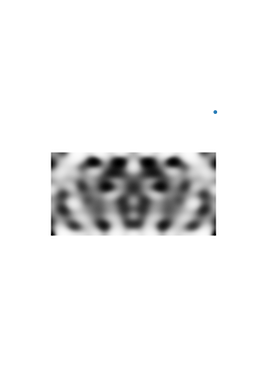

Current iteration: 57
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.00011301 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0382469 s
-----------
on time step 22192 (time=369.867), 0.000180249 s/step
on time step 44392 (time=739.867), 0.000180183 s/step
run 112 finished at t = 829.6333333333333 (49778 timesteps)
Starting adjoint run...
on time step 20632 (time=343.867), 0.000193874 s/step
on time step 44355 (time=739.25), 0.000168614 s/step
run 113 finished at t = 891.8166666666666 (53509 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


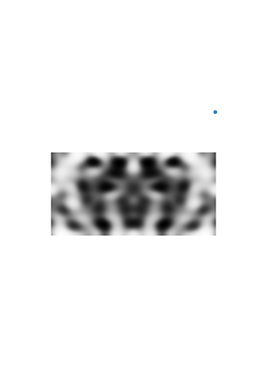

Current iteration: 58
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000120163 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0373631 s
-----------
on time step 22129 (time=368.817), 0.000180764 s/step
on time step 44278 (time=737.967), 0.000180599 s/step
on time step 63250 (time=1054.17), 0.000210837 s/step
on time step 85537 (time=1425.62), 0.000179484 s/step
on time step 107991 (time=1799.85), 0.000178143 s/step
run 114 finished at t = 2000.0166666666667 (120001 timesteps)
Starting adjoint run...
on time step 20597 (time=343.283), 0.000194209 s/step
on time step 44588 (time=743.133), 0.000166731 s/step
on time step 68472 (time=1141.2), 0.000167483 s/step
on time step 92593 (time=1543.22), 0.000165832 s/step
on time step 115957 (time=1932.62), 0.000171204 s/step
run 115 finished at t = 20

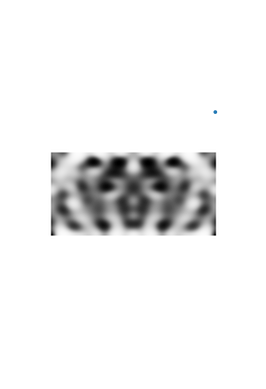

Current iteration: 59
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000231981 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0411232 s
-----------
on time step 17922 (time=298.7), 0.000223197 s/step
on time step 40664 (time=677.733), 0.000175889 s/step
on time step 63667 (time=1061.12), 0.000173896 s/step
on time step 86884 (time=1448.07), 0.000172291 s/step
run 116 finished at t = 1774.5166666666667 (106471 timesteps)
Starting adjoint run...
on time step 21831 (time=363.85), 0.000183232 s/step
on time step 45745 (time=762.417), 0.000167268 s/step
on time step 69665 (time=1161.08), 0.000167225 s/step
on time step 88906 (time=1481.77), 0.000207893 s/step
on time step 112843 (time=1880.72), 0.000167106 s/step
run 117 finished at t = 2000.0166666666667 (120001 timesteps)
Calculating gradient.

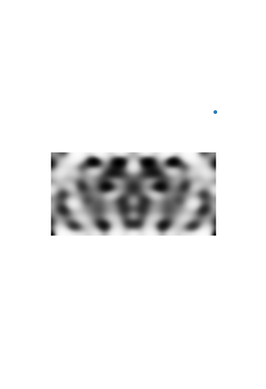

Current iteration: 60
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000112057 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0392301 s
-----------
on time step 22496 (time=374.933), 0.000177816 s/step
run 118 finished at t = 659.7666666666667 (39586 timesteps)
Starting adjoint run...
on time step 21370 (time=356.167), 0.000187182 s/step
on time step 45507 (time=758.45), 0.000165722 s/step
run 119 finished at t = 975.2333333333333 (58514 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


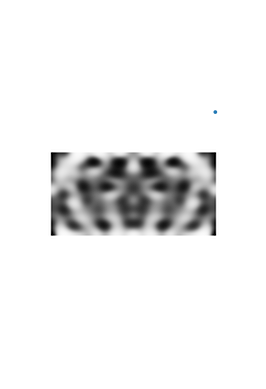

Current iteration: 61
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000111818 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.037576 s
-----------
on time step 22252 (time=370.867), 0.000179765 s/step
on time step 44496 (time=741.6), 0.000179829 s/step
on time step 62529 (time=1042.15), 0.000221819 s/step
on time step 84824 (time=1413.73), 0.000179417 s/step
run 120 finished at t = 1416.5833333333333 (84995 timesteps)
Starting adjoint run...
on time step 21141 (time=352.35), 0.000189213 s/step
on time step 45062 (time=751.033), 0.000167219 s/step
on time step 69353 (time=1155.88), 0.000164675 s/step
on time step 93041 (time=1550.68), 0.000168868 s/step
run 121 finished at t = 1624.3666666666666 (97462 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
   

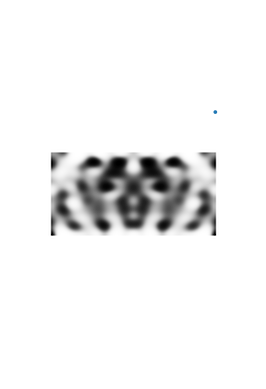

Current iteration: 62
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000108957 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0380611 s
-----------
on time step 22301 (time=371.683), 0.000179365 s/step
run 122 finished at t = 731.05 (43863 timesteps)
Starting adjoint run...
on time step 16477 (time=274.617), 0.000242769 s/step
on time step 40194 (time=669.9), 0.00016866 s/step
run 123 finished at t = 788.6833333333333 (47321 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


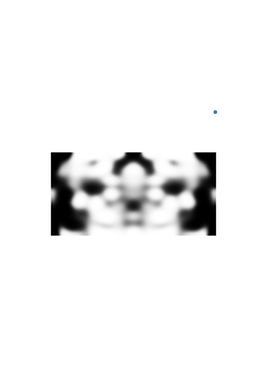

Current iteration: 63
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000108957 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0370901 s
-----------
on time step 22336 (time=372.267), 0.000179086 s/step
on time step 44927 (time=748.783), 0.000177062 s/step
run 124 finished at t = 878.1666666666666 (52690 timesteps)
Starting adjoint run...
on time step 21033 (time=350.55), 0.000190179 s/step
on time step 44447 (time=740.783), 0.000170843 s/step
run 125 finished at t = 997.9833333333333 (59879 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


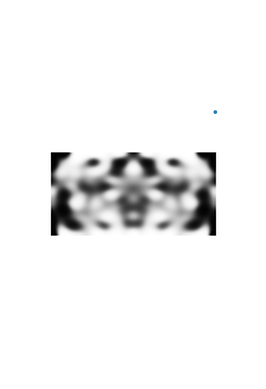

Current iteration: 64
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000113964 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0378771 s
-----------
on time step 21423 (time=357.05), 0.000186723 s/step
on time step 39344 (time=655.733), 0.000223207 s/step
on time step 61700 (time=1028.33), 0.000178924 s/step
on time step 84137 (time=1402.28), 0.000178284 s/step
run 126 finished at t = 1463.6 (87816 timesteps)
Starting adjoint run...
on time step 20913 (time=348.55), 0.000191275 s/step
on time step 44565 (time=742.75), 0.000169124 s/step
on time step 67796 (time=1129.93), 0.000172193 s/step
run 127 finished at t = 1519.7166666666667 (91183 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


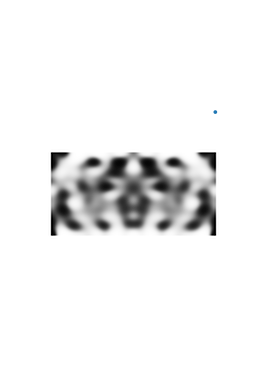

Current iteration: 65
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000113964 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0376511 s
-----------
on time step 21800 (time=363.333), 0.000183492 s/step
on time step 39751 (time=662.517), 0.000222837 s/step
run 128 finished at t = 806.8833333333333 (48413 timesteps)
Starting adjoint run...
on time step 21078 (time=351.3), 0.000189774 s/step
on time step 44824 (time=747.067), 0.000168453 s/step
run 129 finished at t = 881.1999999999999 (52872 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


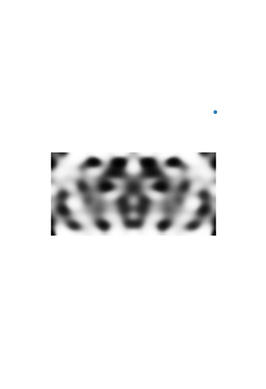

Current iteration: 66
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000111818 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.03756 s
-----------
on time step 21923 (time=365.383), 0.000182458 s/step
on time step 44347 (time=739.117), 0.000178388 s/step
on time step 66710 (time=1111.83), 0.000178874 s/step
run 130 finished at t = 1322.55 (79353 timesteps)
Starting adjoint run...
on time step 20893 (time=348.217), 0.000191454 s/step
on time step 40417 (time=673.617), 0.000204882 s/step
on time step 64375 (time=1072.92), 0.000166965 s/step
on time step 88434 (time=1473.9), 0.00016626 s/step
run 131 finished at t = 1563.7 (93822 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


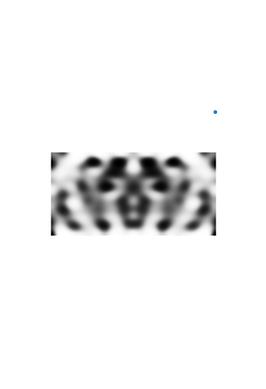

Current iteration: 67
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000108957 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.037503 s
-----------
on time step 22613 (time=376.883), 0.000176892 s/step
on time step 45161 (time=752.683), 0.000177403 s/step
on time step 67648 (time=1127.47), 0.000177888 s/step
run 132 finished at t = 1284.6333333333332 (77078 timesteps)
Starting adjoint run...
on time step 20541 (time=342.35), 0.000194739 s/step
on time step 39640 (time=660.667), 0.000209438 s/step
on time step 63568 (time=1059.47), 0.000167169 s/step
on time step 87294 (time=1454.9), 0.000168593 s/step
run 133 finished at t = 1530.3333333333333 (91820 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


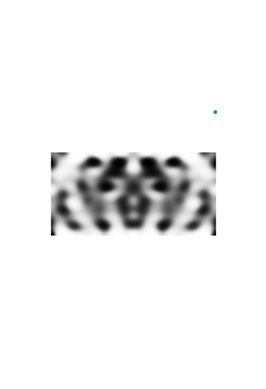

Current iteration: 68
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000110865 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.037339 s
-----------
on time step 22493 (time=374.883), 0.00017784 s/step
on time step 45154 (time=752.567), 0.000176517 s/step
run 134 finished at t = 1022.25 (61335 timesteps)
Starting adjoint run...
on time step 20706 (time=345.1), 0.000193184 s/step
on time step 44086 (time=734.767), 0.00017109 s/step
run 135 finished at t = 1049.55 (62973 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


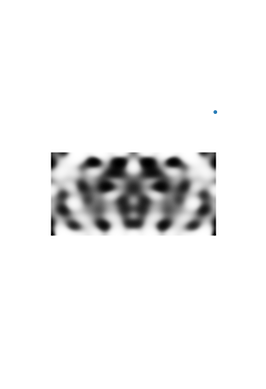

Current iteration: 69
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.00011301 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.038398 s
-----------
on time step 18205 (time=303.417), 0.000219722 s/step
on time step 40798 (time=679.967), 0.000177049 s/step
on time step 63551 (time=1059.18), 0.000175803 s/step
on time step 86453 (time=1440.88), 0.000174664 s/step
run 136 finished at t = 1462.0833333333333 (87725 timesteps)
Starting adjoint run...
on time step 20911 (time=348.517), 0.000191294 s/step
on time step 44692 (time=744.867), 0.000168205 s/step
on time step 68300 (time=1138.33), 0.000169438 s/step
run 137 finished at t = 1486.35 (89181 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


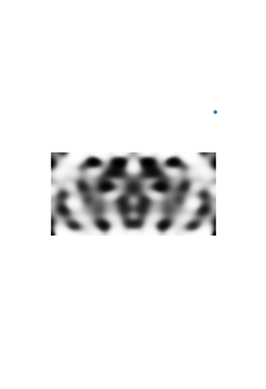

Current iteration: 70
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000111818 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0384402 s
-----------
on time step 17867 (time=297.783), 0.000223883 s/step
on time step 40191 (time=669.85), 0.000179183 s/step
run 138 finished at t = 867.55 (52053 timesteps)
Starting adjoint run...
on time step 21226 (time=353.767), 0.000188455 s/step
on time step 45127 (time=752.117), 0.000167364 s/step
run 139 finished at t = 844.8 (50688 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


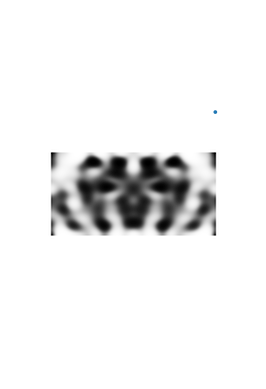

Current iteration: 71
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000113964 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.037725 s
-----------
on time step 22147 (time=369.117), 0.000180616 s/step
on time step 44428 (time=740.467), 0.000179528 s/step
on time step 66935 (time=1115.58), 0.00017773 s/step
on time step 87621 (time=1460.35), 0.000207107 s/step
run 140 finished at t = 1722.95 (103377 timesteps)
Starting adjoint run...
on time step 21242 (time=354.033), 0.000188309 s/step
on time step 45215 (time=753.583), 0.000166855 s/step
on time step 68995 (time=1149.92), 0.000168209 s/step
on time step 93051 (time=1550.85), 0.000166285 s/step
run 141 finished at t = 1559.15 (93549 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0)

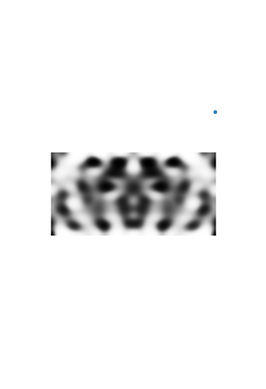

Current iteration: 72
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000108957 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.038064 s
-----------
on time step 22246 (time=370.767), 0.000179813 s/step
on time step 44607 (time=743.45), 0.000178888 s/step
on time step 67120 (time=1118.67), 0.000177681 s/step
run 142 finished at t = 1233.0666666666666 (73984 timesteps)
Starting adjoint run...
on time step 21116 (time=351.933), 0.000189437 s/step
on time step 44886 (time=748.1), 0.00016828 s/step
on time step 68604 (time=1143.4), 0.000168651 s/step
on time step 92232 (time=1537.2), 0.000169297 s/step
run 143 finished at t = 1732.05 (103923 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


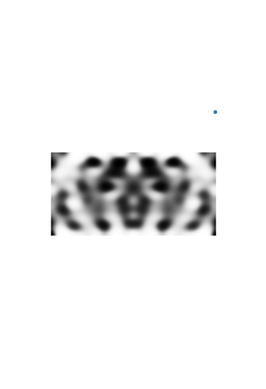

Current iteration: 73
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000113964 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0407391 s
-----------
on time step 22394 (time=373.233), 0.00017862 s/step
run 144 finished at t = 714.3666666666667 (42862 timesteps)
Starting adjoint run...
on time step 20487 (time=341.45), 0.00019525 s/step
on time step 40158 (time=669.3), 0.000203347 s/step
run 145 finished at t = 863.0 (51780 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


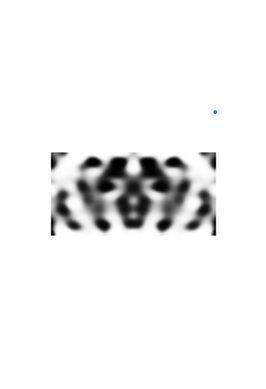

Current iteration: 74
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000108957 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0373011 s
-----------
on time step 22470 (time=374.5), 0.000178022 s/step
run 146 finished at t = 397.3833333333333 (23843 timesteps)
Starting adjoint run...
on time step 20916 (time=348.6), 0.000191248 s/step
run 147 finished at t = 421.65 (25299 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


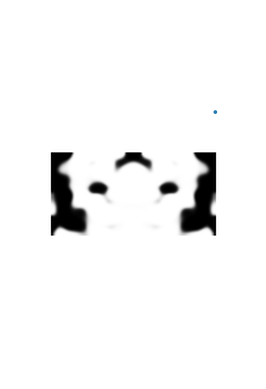

Current iteration: 75
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000109911 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0374651 s
-----------
on time step 22362 (time=372.7), 0.000178881 s/step
on time step 44749 (time=745.817), 0.000178676 s/step
run 148 finished at t = 925.1833333333333 (55511 timesteps)
Starting adjoint run...
on time step 21014 (time=350.233), 0.000190351 s/step
on time step 44682 (time=744.7), 0.00016901 s/step
run 149 finished at t = 838.7333333333333 (50324 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


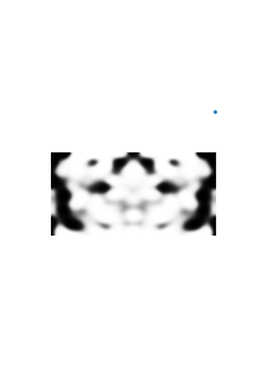

Current iteration: 76
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000111103 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0375502 s
-----------
on time step 18257 (time=304.283), 0.000219101 s/step
run 150 finished at t = 611.2333333333333 (36674 timesteps)
Starting adjoint run...
on time step 20996 (time=349.933), 0.000190517 s/step
run 151 finished at t = 731.05 (43863 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


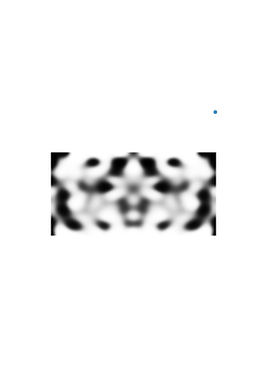

Current iteration: 77
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.00011301 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0388119 s
-----------
on time step 22305 (time=371.75), 0.000179334 s/step
on time step 44633 (time=743.883), 0.00017915 s/step
run 152 finished at t = 829.6333333333333 (49778 timesteps)
Starting adjoint run...
on time step 21000 (time=350), 0.000190483 s/step
on time step 44456 (time=740.933), 0.000170541 s/step
on time step 63918 (time=1065.3), 0.00020553 s/step
on time step 87501 (time=1458.35), 0.000169618 s/step
run 153 finished at t = 1657.7333333333333 (99464 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


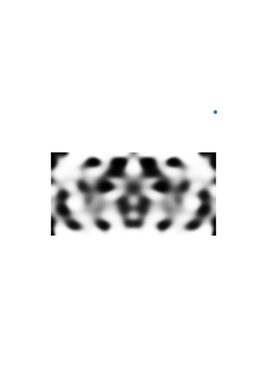

Current iteration: 78
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000115871 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0388341 s
-----------
on time step 22087 (time=368.117), 0.000181107 s/step
on time step 44478 (time=741.3), 0.000178649 s/step
run 154 finished at t = 773.5166666666667 (46411 timesteps)
Starting adjoint run...
on time step 21060 (time=351), 0.000189935 s/step
run 155 finished at t = 721.95 (43317 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


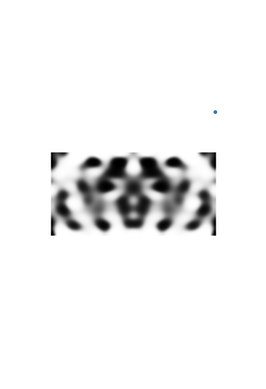

Current iteration: 79
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000111103 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.038698 s
-----------
on time step 22125 (time=368.75), 0.000180803 s/step
run 156 finished at t = 726.5 (43590 timesteps)
Starting adjoint run...
on time step 16778 (time=279.633), 0.00023841 s/step
run 157 finished at t = 632.4666666666667 (37948 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


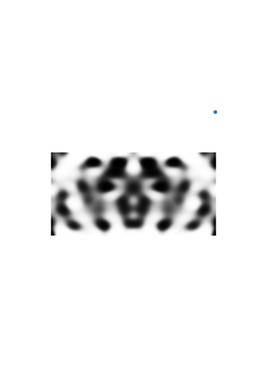

Current iteration: 80
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000118017 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0402591 s
-----------
on time step 22081 (time=368.017), 0.000181151 s/step
on time step 44132 (time=735.533), 0.000181399 s/step
run 158 finished at t = 755.3166666666666 (45319 timesteps)
Starting adjoint run...
on time step 20737 (time=345.617), 0.000192898 s/step
run 159 finished at t = 621.85 (37311 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


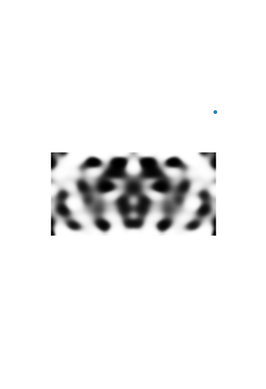

Current iteration: 81
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000113964 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.037992 s
-----------
on time step 22183 (time=369.717), 0.000180321 s/step
run 160 finished at t = 644.6 (38676 timesteps)
Starting adjoint run...
on time step 16284 (time=271.4), 0.000245643 s/step
on time step 39864 (time=664.4), 0.000169641 s/step
run 161 finished at t = 721.95 (43317 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


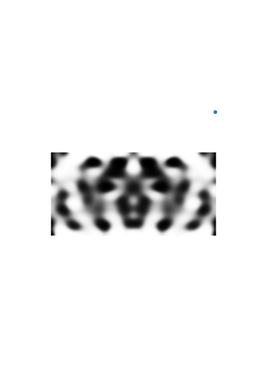

Current iteration: 82
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000113964 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.04357 s
-----------
on time step 22083 (time=368.05), 0.000181138 s/step
run 162 finished at t = 729.5333333333333 (43772 timesteps)
Starting adjoint run...
on time step 21306 (time=355.1), 0.000187746 s/step
on time step 45170 (time=752.833), 0.000167621 s/step
run 163 finished at t = 905.4666666666667 (54328 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


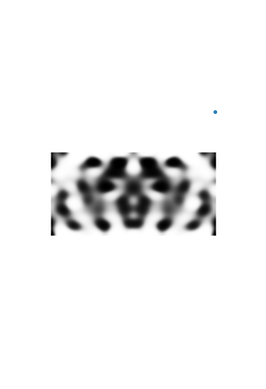

Current iteration: 83
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000108957 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.037725 s
-----------
on time step 22262 (time=371.033), 0.000179685 s/step
run 164 finished at t = 624.8833333333333 (37493 timesteps)
Starting adjoint run...
on time step 20794 (time=346.567), 0.000192368 s/step
run 165 finished at t = 717.4 (43044 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


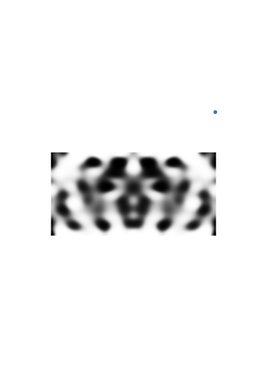

Current iteration: 84
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000111103 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0384078 s
-----------
on time step 22081 (time=368.017), 0.000181158 s/step
run 166 finished at t = 694.65 (41679 timesteps)
Starting adjoint run...
on time step 15555 (time=259.25), 0.000257157 s/step
on time step 39424 (time=657.067), 0.000167588 s/step
run 167 finished at t = 676.45 (40587 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


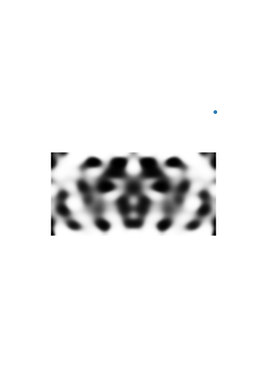

Current iteration: 85
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000109911 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0376749 s
-----------
on time step 22127 (time=368.783), 0.00018078 s/step
on time step 44633 (time=743.883), 0.000177737 s/step
on time step 67057 (time=1117.62), 0.000178386 s/step
run 168 finished at t = 1248.2333333333333 (74894 timesteps)
Starting adjoint run...
on time step 21009 (time=350.15), 0.000190395 s/step
on time step 45006 (time=750.1), 0.000166693 s/step
on time step 68581 (time=1143.02), 0.000169677 s/step
run 169 finished at t = 1413.55 (84813 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


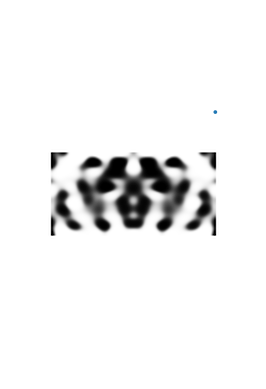

Current iteration: 86
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000118017 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0390668 s
-----------
on time step 21837 (time=363.95), 0.000183182 s/step
run 170 finished at t = 523.2666666666667 (31396 timesteps)
Starting adjoint run...
on time step 21005 (time=350.083), 0.000190434 s/step
run 171 finished at t = 717.4 (43044 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


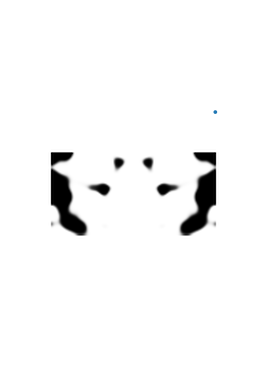

Current iteration: 87
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000110149 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0460012 s
-----------
on time step 22079 (time=367.983), 0.000181169 s/step
on time step 44134 (time=735.567), 0.000181368 s/step
run 172 finished at t = 1061.6833333333334 (63701 timesteps)
Starting adjoint run...
on time step 20907 (time=348.45), 0.00019133 s/step
on time step 40520 (time=675.333), 0.00020395 s/step
run 173 finished at t = 929.7333333333333 (55784 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


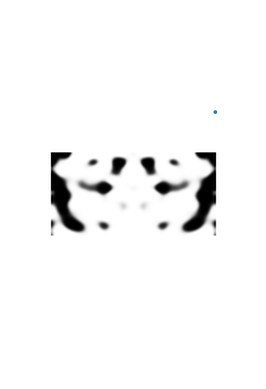

Current iteration: 88
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000112057 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.038372 s
-----------
on time step 21977 (time=366.283), 0.000182016 s/step
on time step 44013 (time=733.55), 0.000181522 s/step
run 174 finished at t = 1054.1 (63246 timesteps)
Starting adjoint run...
on time step 21429 (time=357.15), 0.00018667 s/step
on time step 45358 (time=755.967), 0.000167164 s/step
on time step 69185 (time=1153.08), 0.000167877 s/step
run 175 finished at t = 1230.0333333333333 (73802 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


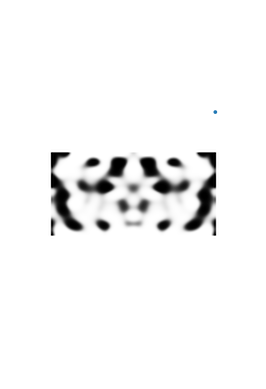

Current iteration: 89
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000123024 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0379629 s
-----------
on time step 22277 (time=371.283), 0.000179558 s/step
on time step 40947 (time=682.45), 0.00021425 s/step
on time step 63339 (time=1055.65), 0.000178642 s/step
run 176 finished at t = 1075.3333333333333 (64520 timesteps)
Starting adjoint run...
on time step 20861 (time=347.683), 0.000191751 s/step
on time step 44813 (time=746.883), 0.000167001 s/step
run 177 finished at t = 935.8 (56148 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


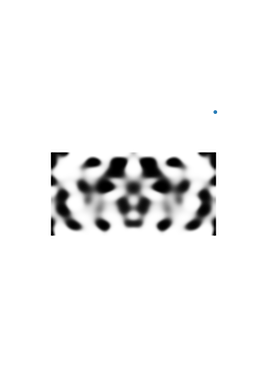

Current iteration: 90
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000108957 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0375969 s
-----------
on time step 22235 (time=370.583), 0.000179903 s/step
run 178 finished at t = 658.25 (39495 timesteps)
Starting adjoint run...
on time step 20773 (time=346.217), 0.000192561 s/step
on time step 44136 (time=735.6), 0.000197257 s/step
run 179 finished at t = 1092.0166666666667 (65521 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


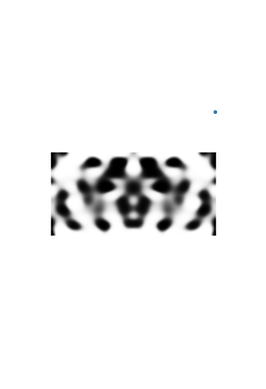

Current iteration: 91
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000117064 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0424969 s
-----------
on time step 22424 (time=373.733), 0.000178386 s/step
on time step 45026 (time=750.433), 0.000176977 s/step
run 180 finished at t = 896.3666666666667 (53782 timesteps)
Starting adjoint run...
on time step 21262 (time=354.367), 0.000188136 s/step
on time step 45189 (time=753.15), 0.000167176 s/step
on time step 69286 (time=1154.77), 0.000165997 s/step
run 181 finished at t = 1205.7666666666667 (72346 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


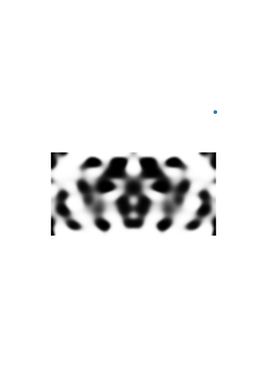

Current iteration: 92
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000118971 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0382121 s
-----------
on time step 22536 (time=375.6), 0.000177499 s/step
on time step 41075 (time=684.583), 0.000215763 s/step
run 182 finished at t = 1049.55 (62973 timesteps)
Starting adjoint run...
on time step 20883 (time=348.05), 0.000191544 s/step
on time step 44980 (time=749.667), 0.000166002 s/step
on time step 69179 (time=1152.98), 0.0001653 s/step
run 183 finished at t = 1210.3166666666666 (72619 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


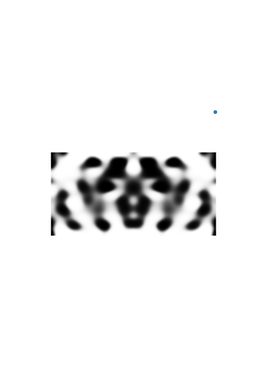

Current iteration: 93
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.00012207 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.037647 s
-----------
on time step 22304 (time=371.733), 0.00017934 s/step
on time step 44732 (time=745.533), 0.000178354 s/step
run 184 finished at t = 1092.0166666666667 (65521 timesteps)
Starting adjoint run...
on time step 16665 (time=277.75), 0.000240025 s/step
on time step 40314 (time=671.9), 0.000169142 s/step
run 185 finished at t = 1043.4833333333333 (62609 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


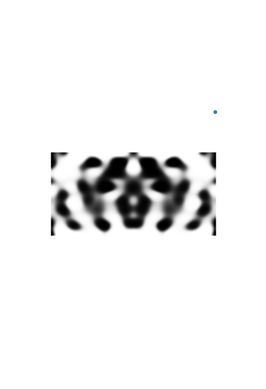

Current iteration: 94
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000111103 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0384331 s
-----------
on time step 22465 (time=374.417), 0.000178057 s/step
on time step 45018 (time=750.3), 0.000177362 s/step
run 186 finished at t = 929.7333333333333 (55784 timesteps)
Starting adjoint run...
on time step 21149 (time=352.483), 0.000189139 s/step
on time step 45256 (time=754.267), 0.000165927 s/step
run 187 finished at t = 1055.6166666666666 (63337 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


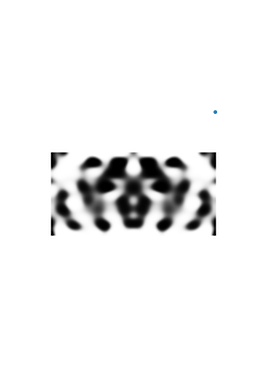

Current iteration: 95
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.00011301 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0442219 s
-----------
on time step 18262 (time=304.367), 0.000219034 s/step
on time step 40433 (time=673.883), 0.000180423 s/step
run 188 finished at t = 679.4833333333333 (40769 timesteps)
Starting adjoint run...
on time step 20844 (time=347.4), 0.00019191 s/step
on time step 44844 (time=747.4), 0.00016667 s/step
run 189 finished at t = 1117.8 (67068 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


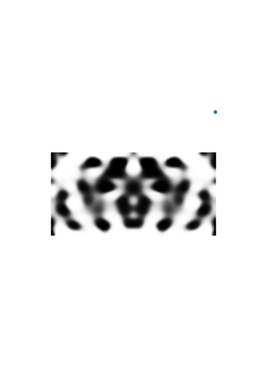

Current iteration: 96
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000111103 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0366511 s
-----------
on time step 22831 (time=380.517), 0.000175204 s/step
on time step 45430 (time=757.167), 0.000177002 s/step
run 190 finished at t = 894.85 (53691 timesteps)
Starting adjoint run...
on time step 21207 (time=353.45), 0.000188624 s/step
on time step 40492 (time=674.867), 0.000207423 s/step
on time step 64095 (time=1068.25), 0.000169474 s/step
run 191 finished at t = 1078.3666666666666 (64702 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


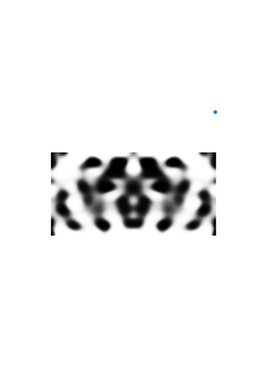

Current iteration: 97
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000109196 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.039072 s
-----------
on time step 22387 (time=373.117), 0.000178687 s/step
on time step 44974 (time=749.567), 0.000177094 s/step
run 192 finished at t = 840.25 (50415 timesteps)
Starting adjoint run...
on time step 21260 (time=354.333), 0.00018815 s/step
on time step 45252 (time=754.2), 0.000166729 s/step
on time step 69033 (time=1150.55), 0.000168204 s/step
run 193 finished at t = 1167.85 (70071 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


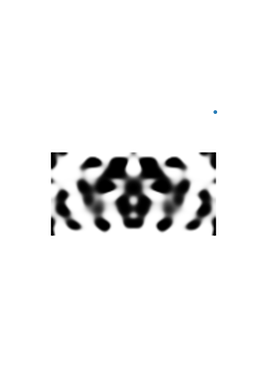

Current iteration: 98
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000111103 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0378468 s
-----------
run 194 finished at t = 341.26666666666665 (20476 timesteps)
Starting adjoint run...
on time step 15895 (time=264.917), 0.000251652 s/step
run 195 finished at t = 364.01666666666665 (21841 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


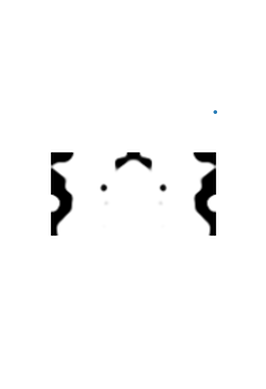

Current iteration: 99
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000150919 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.040092 s
-----------
on time step 22164 (time=369.4), 0.00018048 s/step
run 196 finished at t = 398.9 (23934 timesteps)
Starting adjoint run...
on time step 20999 (time=349.983), 0.000190489 s/step
run 197 finished at t = 470.18333333333334 (28211 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


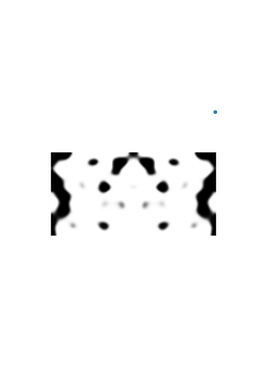

Current iteration: 100
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000112057 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.042552 s
-----------
on time step 22346 (time=372.433), 0.000179008 s/step
run 198 finished at t = 464.1166666666667 (27847 timesteps)
Starting adjoint run...
run 199 finished at t = 273.01666666666665 (16381 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


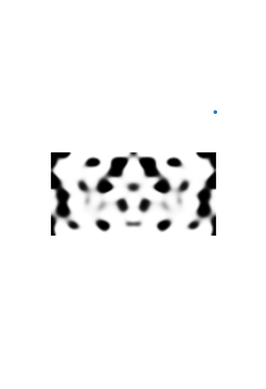

Current iteration: 101
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000112057 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0375049 s
-----------
on time step 22333 (time=372.217), 0.000179111 s/step
run 200 finished at t = 586.9666666666667 (35218 timesteps)
Starting adjoint run...
on time step 20539 (time=342.317), 0.000194756 s/step
run 201 finished at t = 561.1833333333333 (33671 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


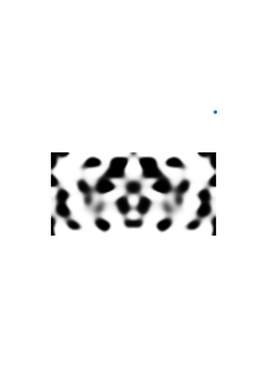

Current iteration: 102
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000114918 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0390081 s
-----------
on time step 22170 (time=369.5), 0.000180431 s/step
on time step 44752 (time=745.867), 0.000177136 s/step
run 202 finished at t = 750.7666666666667 (45046 timesteps)
Starting adjoint run...
on time step 21075 (time=351.25), 0.000189807 s/step
on time step 45381 (time=756.35), 0.000164572 s/step
run 203 finished at t = 954.0 (57240 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


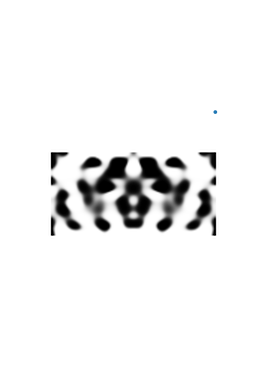

Current iteration: 103
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000108957 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0371919 s
-----------
on time step 22500 (time=375), 0.000177783 s/step
on time step 45136 (time=752.267), 0.000176714 s/step
run 204 finished at t = 866.0333333333333 (51962 timesteps)
Starting adjoint run...
on time step 20970 (time=349.5), 0.000190752 s/step
on time step 39957 (time=665.95), 0.000210674 s/step
run 205 finished at t = 935.8 (56148 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


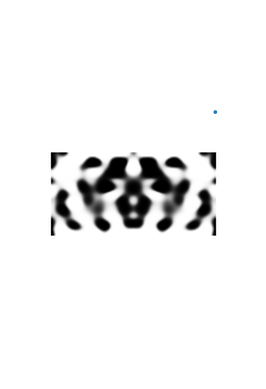

Current iteration: 104
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.00012207 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.044867 s
-----------
on time step 22455 (time=374.25), 0.000178141 s/step
on time step 44966 (time=749.433), 0.000177692 s/step
run 206 finished at t = 954.0 (57240 timesteps)
Starting adjoint run...
on time step 20983 (time=349.717), 0.000190634 s/step
on time step 44743 (time=745.717), 0.000168354 s/step
run 207 finished at t = 1081.4 (64884 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


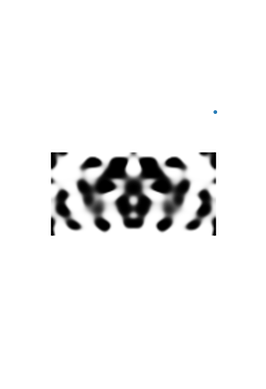

Current iteration: 105
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000109911 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0398629 s
-----------
on time step 22396 (time=373.267), 0.000178606 s/step
on time step 40686 (time=678.1), 0.000218703 s/step
run 208 finished at t = 885.75 (53145 timesteps)
Starting adjoint run...
on time step 20507 (time=341.783), 0.000195058 s/step
on time step 44321 (time=738.683), 0.000167968 s/step
run 209 finished at t = 978.2666666666667 (58696 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


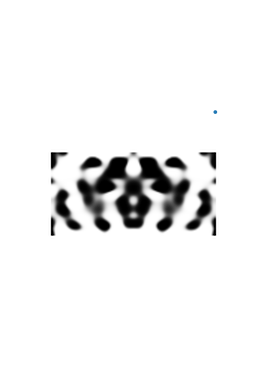

Current iteration: 106
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000111103 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0375981 s
-----------
on time step 22330 (time=372.167), 0.000179134 s/step
on time step 44341 (time=739.017), 0.00018173 s/step
run 210 finished at t = 817.5 (49050 timesteps)
Starting adjoint run...
on time step 20938 (time=348.967), 0.000191042 s/step
on time step 44862 (time=747.7), 0.000167201 s/step
run 211 finished at t = 969.1666666666666 (58150 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


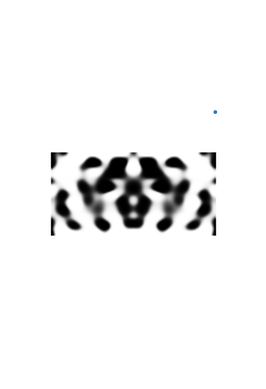

Current iteration: 107
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000111103 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0395331 s
-----------
on time step 22158 (time=369.3), 0.000180528 s/step
on time step 44237 (time=737.283), 0.000181172 s/step
run 212 finished at t = 999.5 (59970 timesteps)
Starting adjoint run...
on time step 21082 (time=351.367), 0.000189743 s/step
on time step 44980 (time=749.667), 0.000167379 s/step
run 213 finished at t = 1005.5666666666666 (60334 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


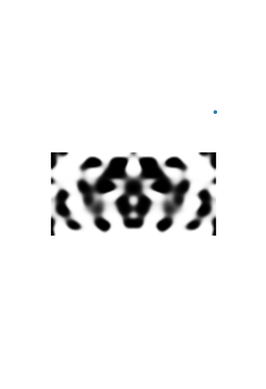

Current iteration: 108
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000109911 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0379782 s
-----------
on time step 22408 (time=373.467), 0.000178509 s/step
on time step 44710 (time=745.167), 0.000179361 s/step
run 214 finished at t = 846.3166666666666 (50779 timesteps)
Starting adjoint run...
on time step 20827 (time=347.117), 0.00019206 s/step
on time step 44392 (time=739.867), 0.000169748 s/step
run 215 finished at t = 1052.5833333333333 (63155 timesteps)
Calculating gradient...
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


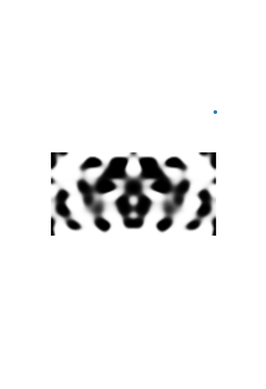

In [12]:
algorithm = nlopt.LD_MMA
n = Nx * Ny  # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5

# lower and upper bounds
lb = np.zeros((Nx * Ny,))
ub = np.ones((Nx * Ny,))

cur_beta = 4
beta_scale = 1.5
num_betas = 9
update_factor = 12
ftol = 1e-5
for iters in range(num_betas):
    solver = nlopt.opt(algorithm, n)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_max_objective(lambda a, g: f(a, g, cur_beta))
    solver.set_maxeval(update_factor)
    solver.set_ftol_rel(ftol)
    x[:] = solver.optimize(x)
    cur_beta = cur_beta * beta_scale

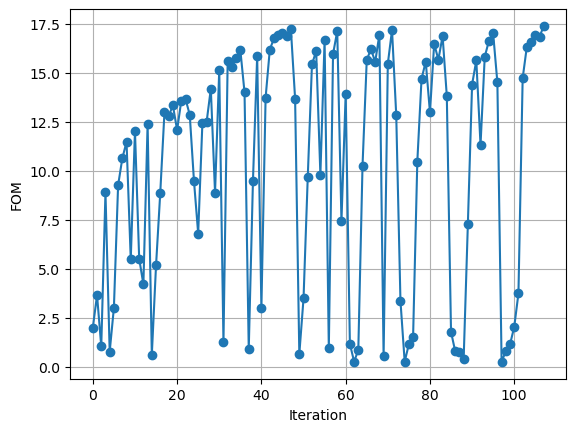

In [13]:
plt.figure()

plt.plot(evaluation_history, "o-")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("FOM")
plt.show()

     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)


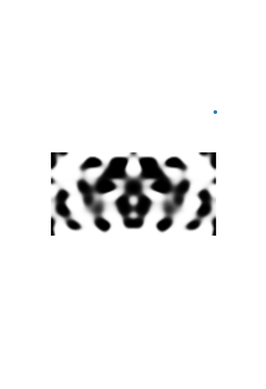

In [14]:
opt.update_design([mapping(x, eta_i, cur_beta/beta_scale)]) # cur_beta/beta_scale is the final beta in the optimization.
plt.figure()
ax = plt.gca()
opt.plot2D(
    False,
    ax=ax,
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
)
circ = Circle((2, 2), minimum_length / 2)
ax.add_patch(circ)
ax.axis("off")
plt.show()

Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000124931 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0366919 s
-----------
on time step 22641 (time=377.35), 0.000176677 s/step
on time step 45129 (time=752.15), 0.000177873 s/step
run 216 finished at t = 846.3166666666666 (50779 timesteps)


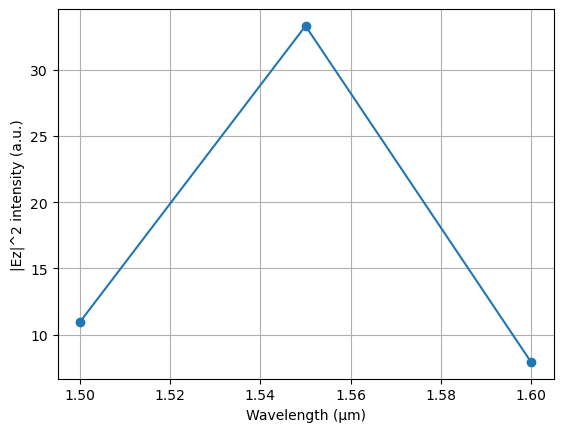

In [15]:
f0, dJ_du = opt([mapping(x, eta_i, cur_beta / beta_scale)], need_gradient=False)
intensities = np.abs(opt.get_objective_arguments()[0][:,1]) ** 2

plt.figure()
plt.plot(wavelengths, intensities, "-o")
plt.grid(True)
plt.xlabel("Wavelength (μm)")
plt.ylabel("|Ez|^2 intensity (a.u.)")
plt.show()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000118971 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0361211 s
-----------
run 0 finished at t = 300.0 (18000 timesteps)
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000128984 s
Working in 2D dimensions.
Computational cell is 6 x 9 x 0 with resolution 30
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.035553 s
-----------
run 0 finished at t = 300.0 (18000 timesteps)
     block, center = (0,0,0)
          size (4,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000156164 s
Working in 2D dimensions.
Computation

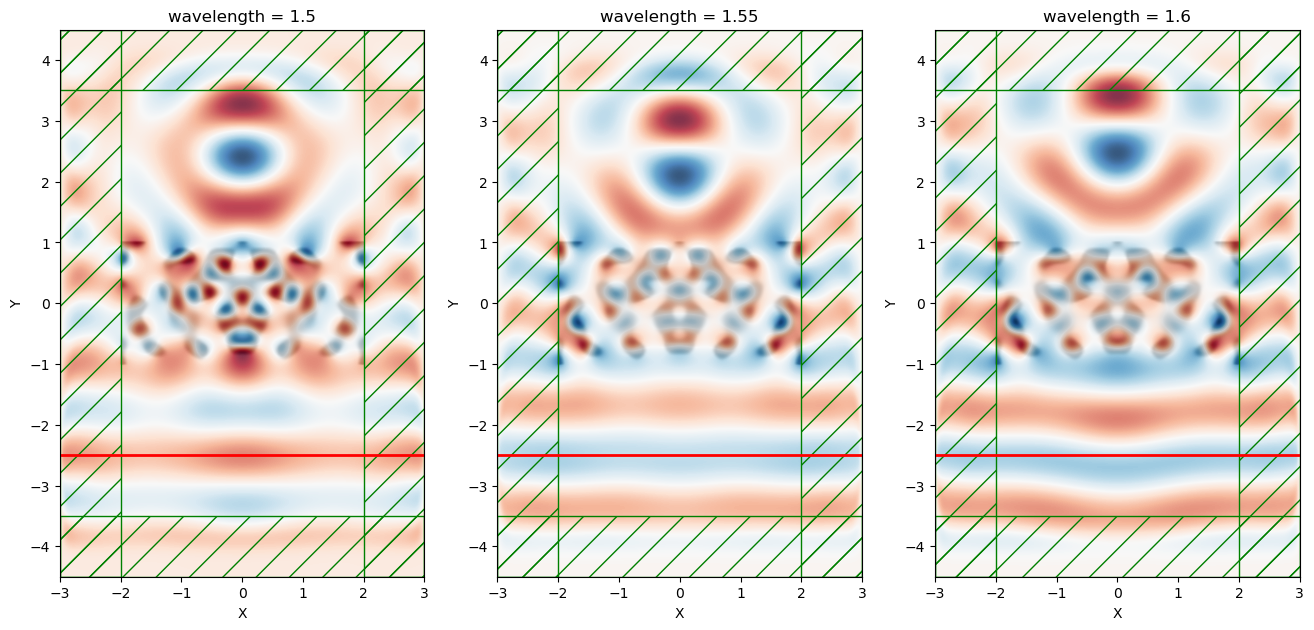

In [16]:
opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
)
src = mp.ContinuousSource(frequency=frequencies[0], fwidth=fwidth, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center)]
opt.sim.change_sources(source)

plt.figure(figsize=(16, 10))

plt.subplot(1,3,1)
plt.title('wavelength = '+str(wavelengths[0]))
opt.sim.run(until=300)
opt.sim.plot2D(fields=mp.Ez)
opt.sim.reset_meep()

opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
)

src = mp.ContinuousSource(frequency=frequencies[1], fwidth=fwidth, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center)]
opt.sim.change_sources(source)

plt.subplot(1,3,2)
plt.title('wavelength = '+str(wavelengths[1]))
opt.sim.run(until=300)
opt.sim.plot2D(fields=mp.Ez)
opt.sim.reset_meep()

opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
)

src = mp.ContinuousSource(frequency=frequencies[2], fwidth=fwidth, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center)]
opt.sim.change_sources(source)

plt.subplot(1,3,3)
plt.title('wavelength = '+str(wavelengths[2]))
opt.sim.run(until=300)
opt.sim.plot2D(fields=mp.Ez)
opt.sim.reset_meep()